In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
img_shape = (1, 64, 64)
batch_size = 128
epochs = 10
lr = 0.0002

In [71]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            #input: N * z_dim * 1 * 1
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(features_g*2, channels_img, 4, 2, 1),
            nn.Tanh() #[-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, z):
        return self.gen(z)

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), #16x16
            self._block(features_d*2, features_d*4, 4, 2, 1), #8x8
            self._block(features_d*4, features_d*8, 4, 2, 1), #4x4
            nn.Conv2d(features_d*8, 1, 4, 2, 0), #1x1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [72]:
img_size = 64

generator = Generator(latent_dim, 1, 64).to(device)
discriminator = Discriminator(1, 64).to(device)

loss_fn = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # ảnh từ [-1, 1]
])
train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

In [81]:
for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # real = torch.ones(batch_size, 1, device=device)
        # fake = torch.zeros(batch_size, 1, device=device)

        z = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
        gen_imgs = generator(z)

        real_loss = loss_fn(discriminator(real_imgs), torch.ones_like(discriminator(real_imgs)))
        fake_loss = loss_fn(discriminator(gen_imgs), torch.zeros_like(discriminator(gen_imgs)))
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        gen_imgs = generator(z)
        g_loss = loss_fn(discriminator(gen_imgs), torch.ones_like(discriminator(gen_imgs)))  # muốn lừa được D

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

Epoch [1/10]  Loss D: 0.4487, Loss G: 1.5379
Epoch [2/10]  Loss D: 0.0328, Loss G: 4.3944
Epoch [3/10]  Loss D: 0.0268, Loss G: 3.9948
Epoch [4/10]  Loss D: 0.2379, Loss G: 2.0730
Epoch [5/10]  Loss D: 0.0361, Loss G: 5.0372
Epoch [6/10]  Loss D: 0.0367, Loss G: 4.3178
Epoch [7/10]  Loss D: 0.6558, Loss G: 0.6186
Epoch [8/10]  Loss D: 0.0142, Loss G: 5.0979
Epoch [9/10]  Loss D: 4.4179, Loss G: 3.7100
Epoch [10/10]  Loss D: 0.0297, Loss G: 4.6602


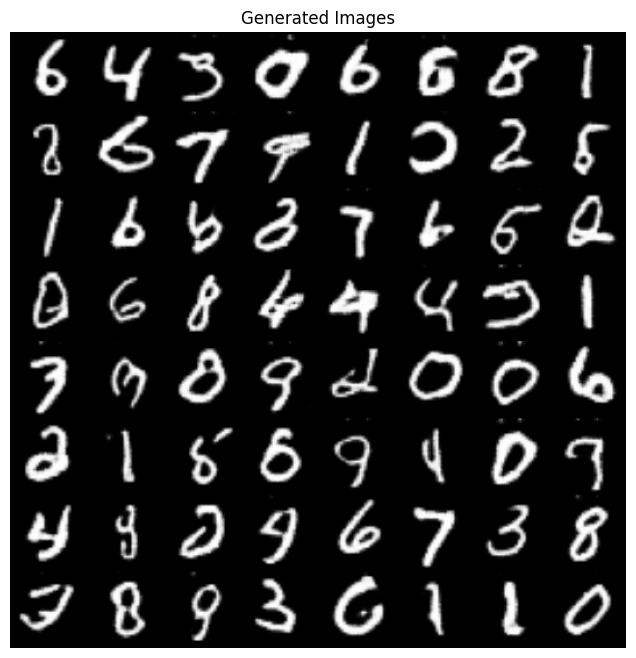

In [82]:
generator.eval()
z = torch.randn(64, latent_dim, 1, 1).to(device)
fake_imgs = generator(z).detach().cpu()

# Chuyển về ảnh [0, 1] để hiển thị
fake_imgs = fake_imgs * 0.5 + 0.5

grid = make_grid(fake_imgs, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Generated Images')
plt.show()

In [64]:
def test():
    N, in_channels, H, W = 128, 1, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    print(gen(z).shape)
    # assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    # print("Success, tests passed!")


if __name__ == "__main__":
    test()

torch.Size([128, 1, 64, 64])
